<a href="https://colab.research.google.com/github/Fareeda84/DL4SEAS/blob/master/Climate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building CNN network to predict temp and rainfall in 6 regions (ENI, ESI, NNI, NSI, WNI, WSI) in New Zealand

In [86]:
# Importing main packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

In [87]:
# Code for the normalisation

torch.set_printoptions(precision = 10)

def normalise(t: torch.tensor):
    max: float = t.max()
    min: float = t.min()
    t =  ((t - min) / (max - min)) #implicit broadcasting applied on scalars
    return t

# Building CNN Network

In [88]:
#Building CNN Network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 30276, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=5)
        #note hyperparameter choice is arbitrary except initial in and final out
        #they are dependant on the colour channels (3 since 3 GCMs) and output classes (5 since 5 classes on cat5) respectively

    def forward(self, t):
    # implement the forward pass
    
        # (1) input layer
        t = t #usually omitted since this is obviously trivial; size 360*131

        # (2) hidden conv layer
        t = self.conv1(t) #Haven't implemented wrapping - so after a 5x5 convolution, 
        #discard borders meaning feature maps are now 6 * 127 * 356 (Channels * height * width)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
        #pooling 2x2 with stride 2 - reduces to 6 * 178 * 63

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
        #pooling 2x2 with stride 2 - reduces to 12 * 29 * 87

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 29 * 87)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) #implicitly performed by F.cross_entropy()

        return t

## Reading Rainfall and Temp Data of 6 regions

In [89]:
#Reading Rainfall files of ENI region
Data_Rain_ENI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_ENI_regional_ave_time_series.csv", sep=",", skiprows=1, header=None )
labels_Rain_ENI = Data_Rain_ENI[Data_Rain_ENI.columns[3]].astype(int) #cat5 column - so 5 prediction classes 


In [90]:
# Reading rainfall file of ESI region
Data_Rain_ESI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_ESI_regional_ave_time_series.csv", sep=',' )
labels_Rain_ESI = Data_Rain_ESI['cat5'].astype(int) #cat5 column - so 5 prediction classes 


In [91]:
# Reading rainfall file of NNI region 
Data_Rain_NNI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_NNI_regional_ave_time_series.csv")
labels_Rain_NNI = Data_Rain_NNI['cat5'].astype(int) #cat5 column - so 5 prediction classes 


In [92]:
#Reading rainfall file of NSI region
Data_Rain_NSI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_NSI_regional_ave_time_series.csv")
labels_Rain_NSI = Data_Rain_NSI['cat5'].astype(int) #cat5 column - so 5 prediction classes 


In [93]:

# Reading rainfall file of WNI region
Data_Rain_WNI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_WNI_regional_ave_time_series.csv")
labels_Rain_WNI = Data_Rain_WNI['cat5'].astype(int) #cat5 column - so 5 prediction classes 


In [94]:
#Reading rainfall file of WSI region
Data_Rain_WSI = pd.read_csv("drive/My Drive/CNN_project/Target_Rain_WSI_regional_ave_time_series.csv", sep=',')
labels_Rain_WSI = Data_Rain_WSI['cat5'].astype(int) #cat5 column - so 5 prediction classes 


In [95]:
#Reading Temp file of ENI region
Data_temp_ENI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_ENI_regional_ave_time_series.csv", sep=',' )
labels_temp_ENI= Data_temp_ENI['cat5'].astype(int)


In [96]:
#Reading Temp file of ESI region
Data_temp_ESI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_ESI_regional_ave_time_series.csv")
labels_temp_ESI = Data_temp_ESI['cat5'].astype(int)

In [97]:
# Reading Temp file of NNI region
Data_temp_NNI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_NNI_regional_ave_time_series.csv")
labels_temp_NNI = Data_temp_NNI['cat5'].astype(int)

In [98]:
# Reading Temp file of NSI region
Data_temp_NSI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_NSI_regional_ave_time_series.csv")
labels_temp_NSI = Data_temp_NSI['cat5'].astype(int)

In [99]:
# Reading Temp file of WNI region
Data_temp_WNI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_WNI_regional_ave_time_series.csv")
labels_temp_WNI = Data_temp_WNI['cat5'].astype(int)

In [100]:
# Reading Temp file of WSI region
Data_temp_WSI = pd.read_csv("drive/My Drive/CNN_project/Target_TMean_WSI_regional_ave_time_series.csv")
labels_temp_WSI = Data_temp_WSI['cat5'].astype(int)

# 3 output files of GCM model 

In [101]:
#Reading in GCM CSVs with pandas
precip = pd.read_csv("drive/My Drive/CNN_project/PRECIP_1993_2016_ecmwf.csv", sep=",",skiprows=3,  header=None )
precip = precip.drop(precip.columns[0], axis=1)


In [102]:
t2m = pd.read_csv("drive/My Drive/CNN_project/T2M_1993_2016_ecmwf.csv", sep=",", skiprows=3, header=None)
t2m = t2m.drop(t2m.columns[0], axis=1)



In [103]:
z850 = pd.read_csv("drive/My Drive/CNN_project/Z850_1993_2016_ecmwf.csv", sep=",", skiprows=4, header=None)
z850 = z850.drop(z850.columns[0], axis=1)


# Converting GCM outputs to Pytorch tensors

In [104]:
#converting to pytorch tensors
#labelsTensor = (torch.from_numpy(labels.values).type(torch.LongTensor)+2 ) #cat5 in form -2, -1, 0, 1, 2; 
#we want 0 to 5 for brevity
precip = torch.from_numpy(precip.values).type(torch.FloatTensor)
t2m = torch.from_numpy(t2m.values).type(torch.FloatTensor)
z850 = torch.from_numpy(z850.values).type(torch.FloatTensor)

In [105]:
 #Unflattening GCMs
precip = precip.reshape(288, 131, 360)
t2m = t2m.reshape(288, 131, 360)
z850 = z850.reshape(288, 131, 360)

In [106]:
#normalising GCMs
precip = normalise(precip)
t2m = normalise(t2m)
z850 = normalise(z850)

In [108]:
 #Stacking each GCM of each variable as a channel of the input tensor
dataTensor = torch.stack([precip, t2m, z850], dim=1)


# Training CNN
Network is trained by using SGD optimiser with learning rate 0.01

In [109]:
#Initialising the CNN and gradient descender (optimizer)
network = Network()
#network.cuda()
optimizer = optim.SGD(network.parameters(), lr = 0.01)

# 25.6% accuracy if learning rate is 0.001 and 0.1

Converting labels into tensors

In [110]:
# Function that will convert labels into Pytorch tensors
def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)+2) #cat5 in form -2, -1, 0, 1, 2;

   

# Data split for calculating training and validation loss
Data is divided into training set of initial 200 data points, validation set of next 50 data points  and test set of last 38 data points.
Batch size of 10 is considered for training and validation process.
Batch size of 38 is considered for testing process.

In [111]:
# Spliting teh dataTensors into training, validation and test tensors 

trainTensor = dataTensor[:200]
validTensor = dataTensor[200:250]
testTensor = dataTensor[250:] 

Pytorch dataset and dataloader are created for mini batch smpling without replacement in randomised order

In [112]:
#Creating pytorch dataset and dataloader for easy access to minibatch sampling without replacement in randomnised order
trainset = torch.utils.data.TensorDataset(trainTensor, labelsTensors[:200])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
validset = torch.utils.data.TensorDataset(validTensor, labelsTensors[200:250])
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False)
testset = torch.utils.data.TensorDataset(testTensor, labelsTensors[250:])
testloader = torch.utils.data.DataLoader(testset, batch_size=38, shuffle=False)


Calculating training and validation loss

In [ ]:
%%time

labelsTensors = labels_Tensors(labels_temp_NNI)

model = network
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, 100):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in trainloader:
        
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = F.cross_entropy(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() 
        
    # validate-the-model
    model.eval()
    for data, target in validloader:
        
       output = model(data)
        
        loss = F.cross_entropy(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() 
    
    # calculate-average-losses
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.579701 	Validation Loss: 1.727378
Epoch: 2 	Training Loss: 1.579605 	Validation Loss: 1.712992
Epoch: 3 	Training Loss: 1.577786 	Validation Loss: 1.726876
Epoch: 4 	Training Loss: 1.575975 	Validation Loss: 1.740369
Epoch: 5 	Training Loss: 1.575541 	Validation Loss: 1.731271
Epoch: 6 	Training Loss: 1.575107 	Validation Loss: 1.718498
Epoch: 7 	Training Loss: 1.573846 	Validation Loss: 1.729493
Epoch: 8 	Training Loss: 1.572414 	Validation Loss: 1.720910
Epoch: 9 	Training Loss: 1.570214 	Validation Loss: 1.724072
Epoch: 10 	Training Loss: 1.569261 	Validation Loss: 1.715535
Epoch: 11 	Training Loss: 1.566271 	Validation Loss: 1.754202
Epoch: 12 	Training Loss: 1.565685 	Validation Loss: 1.723741
Epoch: 13 	Training Loss: 1.564323 	Validation Loss: 1.739405
Epoch: 14 	Training Loss: 1.560569 	Validation Loss: 1.743439
Epoch: 15 	Training Loss: 1.560340 	Validation Loss: 1.699511
Epoch: 16 	Training Loss: 1.555975 	Validation Loss: 1.736276
Epoch: 17 	Traini

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
       
         outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 31.57894736842105 %


# Training and Validation loss plot

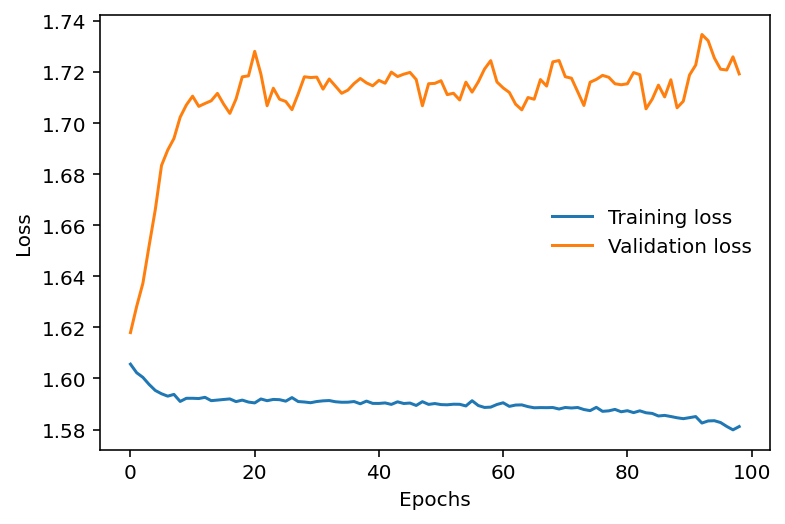

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.savefig('drive/My Drive/CNN_project/Train_Vaild.png')

# Data is divide into Training set of initial 250 data points and test set of last 38 data points to train and test the network.

In [ ]:
#Split the dataTensor into training and test tensors for explicit holdout

train_Tensor = dataTensor[:250]
test_Tensor = dataTensor[250:] #38/288 for testing, or about 13.2%


In [63]:
# Train_set run of NNI temp data 
labelsTensors = labels_Tensors(labels_temp_NSI) 
trainset = torch.utils.data.TensorDataset(train_Tensor, labelsTensors[:250])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

epochLossSum = 0
for epoch in range(0, 250):
    batchNo = 0
    epochCorrect = 0
    prevloss = epochLossSum
    epochLossSum = 0

    for images, labels in trainloader: #shuffled minibatches
        batchNo += 1
        preds0 = network(images)
        loss0 = F.cross_entropy(preds0, labels)  #loss on this batch before gradient descent

        optimizer.zero_grad()
        loss0.backward() #this call updates the gradients in network
        optimizer.step()
        preds1 = network(images)
        loss1 = F.cross_entropy(preds1, labels) #loss on this batch after gradient descent (expect decrease)
        
        #nb loss0, preds0 are loss and predictions before training on this batch, loss1, pred1 are after training on this batch (needed to see how much of a difference this batch made)

        epochLossSum += loss0.item()
        epochCorrect += preds0.argmax(dim=1).eq(labels).int().sum().item()
        #print("Minibatch ", batchNo, ":\t", round(loss0.item(), 5), "(before gd)\t", round(loss1.item(), 5), "(after gd)\t", preds1.argmax(dim=1).eq(labels).int().sum().item(), " (correct predictions)", sep = "" )

    print("epoch: ", epoch, "\tloss: ", round(epochLossSum,5), "\tdifference: " , round(epochLossSum - prevloss, 5) , "\t total_correct", epochCorrect,  "\t%correct:", round((100 * epochCorrect / 250), 3), sep="")
    if (epochCorrect / 250 * 100) > 99 or epoch == 249:
        print("Saving checkpoints: ")
        torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epochLossSum,
            }, "drive/My Drive/CNN_project/check_points_temp_NSI_5.pth.torch") 
        break    
      




epoch: 0	loss: 40.424	difference: 40.424	 total_correct55	%correct:22.0
epoch: 1	loss: 40.24506	difference: -0.17894	 total_correct55	%correct:22.0
epoch: 2	loss: 40.16689	difference: -0.07817	 total_correct55	%correct:22.0
epoch: 3	loss: 40.12298	difference: -0.04392	 total_correct55	%correct:22.0
epoch: 4	loss: 40.06261	difference: -0.06037	 total_correct55	%correct:22.0
epoch: 5	loss: 40.02657	difference: -0.03604	 total_correct55	%correct:22.0
epoch: 6	loss: 40.02421	difference: -0.00236	 total_correct56	%correct:22.4
epoch: 7	loss: 39.99534	difference: -0.02887	 total_correct62	%correct:24.8
epoch: 8	loss: 39.97518	difference: -0.02016	 total_correct62	%correct:24.8
epoch: 9	loss: 39.98096	difference: 0.00578	 total_correct62	%correct:24.8
epoch: 10	loss: 39.98121	difference: 0.00025	 total_correct62	%correct:24.8
epoch: 11	loss: 39.98057	difference: -0.00064	 total_correct62	%correct:24.8
epoch: 12	loss: 39.97429	difference: -0.00628	 total_correct62	%correct:24.8
epoch: 13	loss:

# Confusion matrix 

In [ ]:
# code to plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix for Temp_NSI (18.421% acc.)', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Network testing

tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 3, 3, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0])
result: 7 / 38
test correct %: 18.42105263157895
Confusion matrix, without normalization
tensor([[5, 6, 5, 6, 7],
        [0, 2, 0, 0, 2],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0]])


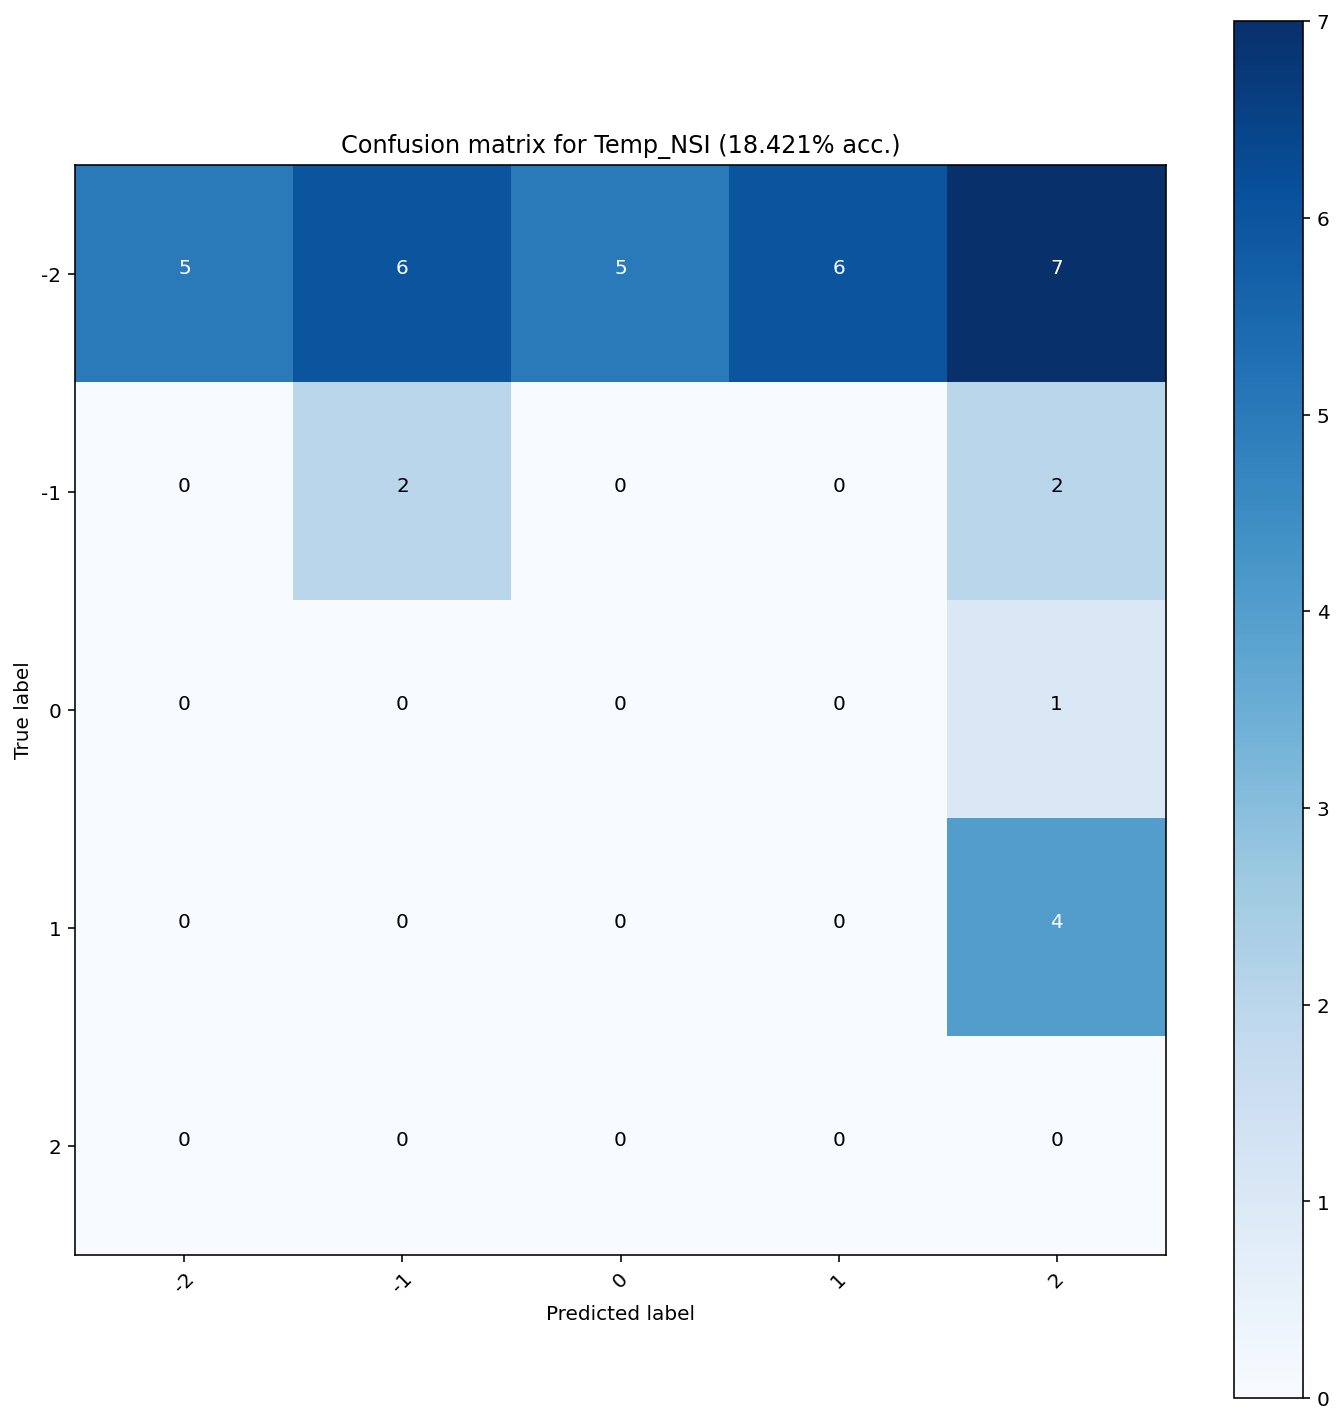

END


In [ ]:
# Test_set run of single dataset

labelsTensors = labels_Tensors(labels_temp_NSI)
testset = torch.utils.data.TensorDataset(test_Tensor, labelsTensors[250:])
testloader = torch.utils.data.DataLoader(testset, batch_size=38, shuffle=False)


checkpoint = torch.load("drive/My Drive/CNN_project/check_points_temp_NSI.pth.torch")
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



for images, labels in testloader:
     preds = network(images)
     correct = preds.argmax(dim=1).eq(labels).int().sum().item()
    #print(testpreds.argmax(dim=1))
     print(labels)
     print("result:", correct, "/ 38")
     print("test correct %:", 100 * correct / 38.0)

    
     confusionStack = torch.stack((labels, preds.argmax(dim=1)), dim=1)
     confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     for p in confusionStack:
         tl, pl = p.tolist()
         confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     pyplot.figure(figsize=(10,10))
     plot_confusion_matrix(confusionMatrix.cpu(), ('-2', '-1', '0', '1', '2'))
     pyplot.show()

    


# Temp accuracy dataframe of 6 regions for 5 runs

In [113]:
 # DataFrame of Temp_accuracy
data_Temp = {"Temp_ENI" : [23.68, 31.578, 34.21, 34.21, 31.578, 31.051], 'Temp_ESI':[26.31, 31.578, 26.315, 26.315, 26.315, 27.366 ], 'Temp_NNI': [44.7, 28.947, 36.842, 36.84, 26.315, 34.728], 'Temp_NSI':[18.42, 18.421, 13.157, 10.52, 13.157, 14.735], 'Temp_WNI':[31.578, 31.578, 36.842, 36.842, 34.21, 34.209], "Temp_WSI":[21.05, 10.526, 15.789, 13.15, 23.684, 16.839  ] }
Table_Temp = pd.DataFrame(data_Temp, index=['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Avg'])
Table_Temp
#Table_Temp.to_csv('drive/My Drive/CNN_project/Table_Temp.png')


,Temp_ENI,Temp_ESI,Temp_NNI,Temp_NSI,Temp_WNI,Temp_WSI
Run1,23.680,26.310,44.700,18.420,31.578,21.050
Run2,31.578,31.578,28.947,18.421,31.578,10.526
Run3,34.210,26.315,36.842,13.157,36.842,15.789
Run4,34.210,26.315,36.840,10.520,36.842,13.150
Run5,31.578,26.315,26.315,13.157,34.210,23.684
Avg,31.051,27.366,34.728,14.735,34.209,16.839


# Rainfall accuracy dataframe of 6 regions for 5 runs


In [61]:
# DataFrame of Rain_accuracy
data_Rain = {"Rain_ENI" : [31.578, 34.21, 23.684, 31.578, 31.578,30.525  ], 'Rain_ESI':[ 28.947, 23.684, 28.947, 23.684, 31.578, 27.368], 'Rain_NNI': [42.105, 39.473, 50.0, 44.736, 47.368, 44.736 ], 'Rain_NSI':[18.421, 23.684, 23.684, 21.052, 21.052, 21.576   ], 'Rain_WNI':[23.68, 21.052, 23.684, 26.315, 34.21 , 25.788   ], "Rain_WSI":[34.21, 31.578, 21.052, 31.578, 36.842 , 31.052 ] }
Table_Rain = pd.DataFrame(data_Rain, index=['Run1', 'Run2', 'Run3', 'Run4', 'Run5 ', 'Avg'])
Table_Rain

,Rain_ENI,Rain_ESI,Rain_NNI,Rain_NSI,Rain_WNI,Rain_WSI
Run1,31.578,28.947,42.105,18.421,23.680,34.210
Run2,34.210,23.684,39.473,23.684,21.052,31.578
Run3,23.684,28.947,50.000,23.684,23.684,21.052
Run4,31.578,23.684,44.736,21.052,26.315,31.578
Run5,31.578,31.578,47.368,21.052,34.210,36.842
Avg,30.525,27.368,44.736,21.576,25.788,31.052


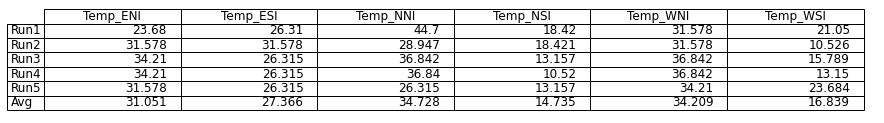

In [85]:
fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, Table_Temp, loc='upper right', colWidths=[0.17]*len(Table_Temp.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.savefig('table.png', transparent=True)

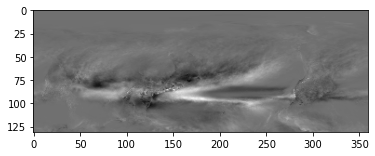

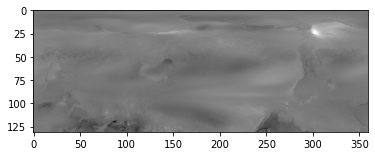

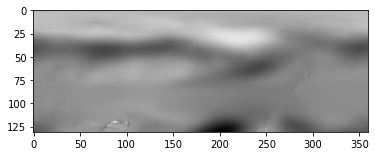

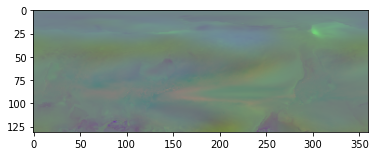

In [ ]:
#Code for plotting input as greyscale images and combining into a single RGB image
pyplot.imshow(precip[0], cmap="gray")
pyplot.show()
pyplot.imshow(t2m[0], cmap="gray")
pyplot.show()
pyplot.imshow(z850[0], cmap="gray")
pyplot.show()
pyplot.imshow(dataTensor[0].cpu().permute(1, 2, 0))
pyplot.show()